In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

In [2]:
import warnings 

In [3]:
warnings.filterwarnings("ignore")

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

In [5]:
import sys 
sys.path.append('../')

In [6]:
from fmds.models.diffusion.diffusion_sde_noise_schedule import   DiffusionSDE

In [7]:
from fmds.utils.io.read import RawDataReader

In [8]:
import  fmds.config as cfg 
from fmds.settings import Settings

In [9]:
rdr = RawDataReader(raw_data_directory=Settings.backfill.paths.RAW_DATA_PATH)

In [10]:
equity_data = rdr.read_30_equities()

In [11]:
# n_samples = 1000

In [12]:
# data , _ = make_swiss_roll(n_samples, noise=0.5)

In [13]:
# data=data[:,[0,2]]

In [14]:
# data.shape

In [15]:
equity_data

,Unnamed: 0,index,tradeDate,ClosePrice,Ticker
0,0,0,NaN,132.21,LLY
1,1,1,2020-01-03 00:00:00,131.77,LLY
2,2,2,2020-01-06 00:00:00,132.26,LLY
3,3,3,2020-01-07 00:00:00,132.51,LLY
4,4,4,2020-01-08 00:00:00,133.71,LLY
...,...,...,...,...,...
42167,42167,1362,2025-06-04 00:00:00,71.37,KO
42168,42168,1363,2025-06-05 00:00:00,70.91,KO
42169,42169,1364,2025-06-06 00:00:00,71.35,KO
42170,42170,1365,2025-06-09 00:00:00,71.77,KO


In [16]:
equity_data.columns.tolist()

['Unnamed: 0', 'index', 'tradeDate', 'ClosePrice', 'Ticker']

In [17]:
equity_data=equity_data[['tradeDate', 'ClosePrice', 'Ticker']].dropna().reset_index(drop=True)

In [18]:
equity_data

,tradeDate,ClosePrice,Ticker
0,2020-01-03 00:00:00,131.77,LLY
1,2020-01-06 00:00:00,132.26,LLY
2,2020-01-07 00:00:00,132.51,LLY
3,2020-01-08 00:00:00,133.71,LLY
4,2020-01-09 00:00:00,135.92,LLY
...,...,...,...
42055,2025-06-04 00:00:00,71.37,KO
42056,2025-06-05 00:00:00,70.91,KO
42057,2025-06-06 00:00:00,71.35,KO
42058,2025-06-09 00:00:00,71.77,KO


In [19]:
equity_data['Ticker'].nunique()

32

In [20]:
equity_data['Ticker'].unique()

array(['LLY', 'MCD', 'MMM', 'MRK', 'MSFT', 'NVDA', 'PFE', 'PG', 'TRV',
       'TSLA', 'UNH', 'V', 'VZ', 'WMT', 'XOM', 'AAPL', 'AXP', 'BA', 'CAT',
       'COST', 'CSCO', 'CVX', 'DO', 'DIS', 'GE', 'GS', 'HD', 'IBM',
       'INTC', 'JNJ', 'JMP', 'KO'], dtype=object)

In [21]:
equity_data['tradeDate'] = pd.to_datetime(equity_data['tradeDate'], errors='coerce').dt.date
equity_data['ClosePrice'] = pd.to_numeric(equity_data['ClosePrice'], errors='coerce')


In [22]:
equity_data.dropna(inplace = True) 

In [23]:
equity_data

,tradeDate,ClosePrice,Ticker
0,2020-01-03,131.77,LLY
1,2020-01-06,132.26,LLY
2,2020-01-07,132.51,LLY
3,2020-01-08,133.71,LLY
4,2020-01-09,135.92,LLY
...,...,...,...
42055,2025-06-04,71.37,KO
42056,2025-06-05,70.91,KO
42057,2025-06-06,71.35,KO
42058,2025-06-09,71.77,KO


In [24]:
# equity_data = equity_data[equity_data['Ticker'].isin([  'MSFT', 'NVDA',  'XOM', 'AAPL',  'IBM' ])]

In [25]:
equity_data.sort_values(by ='tradeDate', ascending = True, inplace = True)

In [26]:
equity_data['prior_1D_return'] = equity_data['ClosePrice']/ equity_data.groupby('Ticker')['ClosePrice'].shift(1)-1

In [27]:
equity_data

,tradeDate,ClosePrice,Ticker,prior_1D_return
0,2020-01-03,131.7700,LLY,NaN
17759,2020-01-03,39.2967,WMT,NaN
4098,2020-01-03,87.0092,MRK,NaN
6830,2020-01-03,5.9018,NVDA,NaN
33394,2020-01-03,231.5800,GS,NaN
...,...,...,...,...
28686,2025-06-10,65.1500,CSCO,-0.011381
9562,2025-06-10,24.3000,PFE,0.013767
27320,2025-06-10,1007.2700,COST,0.001083
10928,2025-06-10,162.8400,PG,0.001722


In [28]:
equity_data[equity_data['Ticker'] == 'DO'].sort_values(by = 'tradeDate', ascending = True)

,tradeDate,ClosePrice,Ticker,prior_1D_return
30053,2022-03-31,7.13,DO,NaN
30054,2022-04-01,6.89,DO,-0.033661
30055,2022-04-04,7.00,DO,0.015965
30056,2022-04-05,6.78,DO,-0.031429
30057,2022-04-06,6.75,DO,-0.004425
...,...,...,...,...
30657,2024-08-27,14.34,DO,-0.007612
30658,2024-08-28,14.21,DO,-0.009066
30659,2024-08-29,14.29,DO,0.005630
30660,2024-08-30,14.34,DO,0.003499


In [29]:
equity_data['tradeDate'] = pd.to_datetime(equity_data['tradeDate'] ).dt.date

In [30]:
equity_data['tradeDate'].dtype

dtype('O')

In [31]:
# equity_data['tradeDate'] = pd.to_datetime(equity_data['tradeDate'] ) 


In [32]:
data = equity_data.pivot_table(index= 'tradeDate', 
                               columns = 'Ticker',
                               values = 'prior_1D_return').dropna(axis=1, 
                                                 how='all').dropna(axis=0,
                                                                   how='all').fillna(0)

In [33]:
data.abs().max()

Ticker
AAPL    0.153288
AXP     0.218823
BA      0.243186
CAT     0.142822
COST    0.124513
CSCO    0.137304
CVX     0.227407
DIS     0.144123
DO      0.121569
GE      0.151592
GS      0.175803
HD      0.197938
IBM     0.129642
INTC    0.260585
JMP     0.448692
JNJ     0.079977
KO      0.096725
LLY     0.156798
MCD     0.181255
MMM     0.229906
MRK     0.098630
MSFT    0.147390
NVDA    0.243696
PFE     0.108552
PG      0.120090
TRV     0.208004
TSLA    0.226900
UNH     0.223797
V       0.138426
VZ      0.092705
WMT     0.117083
XOM     0.126868
dtype: float64

In [34]:
data.shape

(1365, 32)

In [35]:
data = torch.tensor(np.array(data), dtype = torch.float32)

In [36]:
data

tensor([[ 0.0080, -0.0043,  0.0029,  ..., -0.0022, -0.0020,  0.0077],
        [-0.0047, -0.0052,  0.0106,  ..., -0.0111, -0.0093, -0.0082],
        [ 0.0161,  0.0173, -0.0175,  ...,  0.0018, -0.0034, -0.0151],
        ...,
        [ 0.0164,  0.0220,  0.0085,  ...,  0.0115, -0.0050,  0.0240],
        [-0.0121, -0.0030,  0.0318,  ..., -0.0034, -0.0002,  0.0067],
        [ 0.0061, -0.0068, -0.0082,  ...,  0.0110, -0.0013,  0.0214]])

In [37]:
from fmds.models.rmt.CleanseMatrix import CleanseMatrix

In [38]:
?CleanseMatrix

Init signature:
CleanseMatrix(
    use_shrinkage: bool,
    shrinkage_regularizer: float,
    detone: bool,
    market_components_max_index: int,
    grid_size: int = 1000,
    kernel: str = 'gaussian',
    cv: Union[int, sklearn.model_selection._split.BaseCrossValidator] = 100,
    min_bandwidth_grid_exponent: int = -3,
    max_bandwidth_grid_exponent: int = 1,
    bandwidth_grid_size: int = 250,
    initial_variance: float = 0.5,
    epsilon: float = 1e-05,
    min_q: float = 0.5,
    max_q: float = 20,
    q_grid_size: int = 20,
    verbose: bool = True,
)
Docstring:      <no docstring>
File:           ~/Documents/Projects/omroot_repos/FMDS/fmds/models/rmt/CleanseMatrix.py
Type:           type
Subclasses:     

In [39]:
std = np.array(data).std(axis=0)
q = round(data.shape[0]/data.shape[1])

In [41]:
q

43

In [42]:
matrix_cleanser = CleanseMatrix(   use_shrinkage = False,
                                     shrinkage_regularizer = False,
                                     detone = False,
                                     market_components_max_index = 1,
                                                   cv=5,
                               min_q = q,
    max_q = q )

In [43]:
data

tensor([[ 0.0080, -0.0043,  0.0029,  ..., -0.0022, -0.0020,  0.0077],
        [-0.0047, -0.0052,  0.0106,  ..., -0.0111, -0.0093, -0.0082],
        [ 0.0161,  0.0173, -0.0175,  ...,  0.0018, -0.0034, -0.0151],
        ...,
        [ 0.0164,  0.0220,  0.0085,  ...,  0.0115, -0.0050,  0.0240],
        [-0.0121, -0.0030,  0.0318,  ..., -0.0034, -0.0002,  0.0067],
        [ 0.0061, -0.0068, -0.0082,  ...,  0.0110, -0.0013,  0.0214]])

In [44]:
matrix_cleanser.fit(pd.DataFrame(np.array(data)).corr())

For q=43.0, the optimal variance is 1.0 , and objective function is 2404.54,and max random eigen value: 1.33,and # of signal factors: 3
For q=43.0, the optimal variance is 1.0 , and objective function is 2404.54,and max random eigen value: 1.33,and # of signal factors: 3
For q=43.0, the optimal variance is 1.0 , and objective function is 2404.54,and max random eigen value: 1.33,and # of signal factors: 3
For q=43.0, the optimal variance is 1.0 , and objective function is 2404.54,and max random eigen value: 1.33,and # of signal factors: 3
For q=43.0, the optimal variance is 1.0 , and objective function is 2404.54,and max random eigen value: 1.33,and # of signal factors: 3
For q=43.0, the optimal variance is 1.0 , and objective function is 2404.54,and max random eigen value: 1.33,and # of signal factors: 3
For q=43.0, the optimal variance is 1.0 , and objective function is 2404.54,and max random eigen value: 1.33,and # of signal factors: 3
For q=43.0, the optimal variance is 1.0 , and ob

In [45]:
np.linalg.cond(matrix_cleanser.cleansed_matrix)

27.72696991017134

In [46]:
import numpy as np

def correlation2covariance(correlation_matrix: np.ndarray, std: np.ndarray) -> np.ndarray:
    """
    Converts a correlation matrix into a covariance matrix.
    
    Args:
        correlation_matrix: input correlation matrix (NxN)
        std: array of standard deviations of the variables (length N)
        
    Returns:
        covariance_matrix: output covariance matrix (NxN)
    """
    covariance_matrix = correlation_matrix * np.outer(std, std)
    return covariance_matrix


In [47]:
len(std)

32

In [48]:
np.linalg.cond(correlation2covariance(correlation_matrix=matrix_cleanser.cleansed_matrix,
                       std = std))

73.31740611727584

In [49]:
class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, 
                 channels_data=32, 
                 layers=5, 
                 channels=512, 
                 channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.channels_t % 2 == 1:  # zero pad
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t):
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        x = x + t 
        x = self.blocks(x)
        x = self.out_projection(x)
        return x

In [50]:
model = MLP(layers=5, channels=512)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [51]:
import tqdm
import math
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [52]:
# data = torch.Tensor(sampled_points)
training_steps = 100_000
batch_size = 64
pbar = tqdm.tqdm(range(training_steps))
losses = []
for i in pbar:
    x1 = data[torch.randint(data.size(0), (batch_size,))]
    x0 = torch.randn_like(x1)
    target = x1 - x0
    t = torch.rand(x1.size(0))
    xt = (1 - t[:, None]) * x0 + t[:, None] * x1
    pred = model(xt, t)  # also add t here
    loss = ((target - pred)**2).mean()
    loss.backward()
    optim.step()
    optim.zero_grad()
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())

100%|██████████████████████| 100000/100000 [12:11<00:00, 136.65it/s, loss=0.027]


In [53]:
torch.manual_seed(42)
model.eval().requires_grad_(False)
xt = torch.randn(1500, 32)
steps = 1000
plot_every = 100
for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
    pred = model(xt, t.expand(xt.size(0)))
    xt = xt + (1 / steps) * pred
model.train().requires_grad_(True)
print("Done Sampling")

Done Sampling


In [54]:
data_np = data.detach().numpy()
data_np = data_np[~np.isnan(data_np).any(axis=1)]
synthetic_data_np = xt.detach().numpy()
synthetic_data_np = synthetic_data_np[~np.isnan(synthetic_data_np).any(axis=1)]

In [55]:
data_np.shape

(1365, 32)

In [56]:
synthetic_data_np.shape

(1500, 32)

In [57]:
np.linalg.cond(pd.DataFrame(data_np).cov())

113.73615544814133

In [58]:
np.linalg.cond(pd.DataFrame(synthetic_data_np).cov())

42.93146679878643

In [59]:
from research.plots import qqplot, qqplot_against_normal

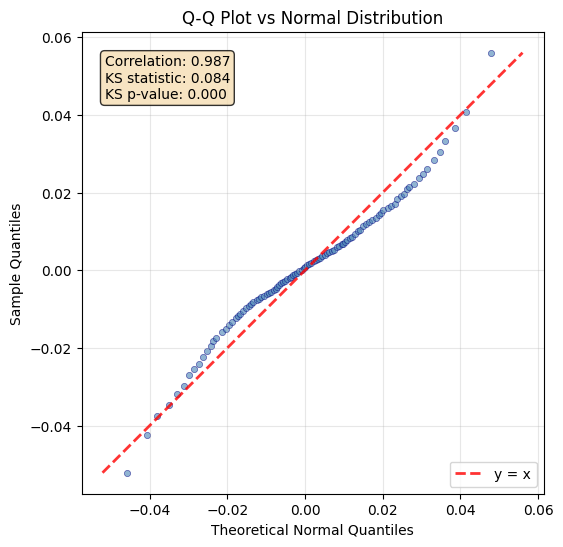

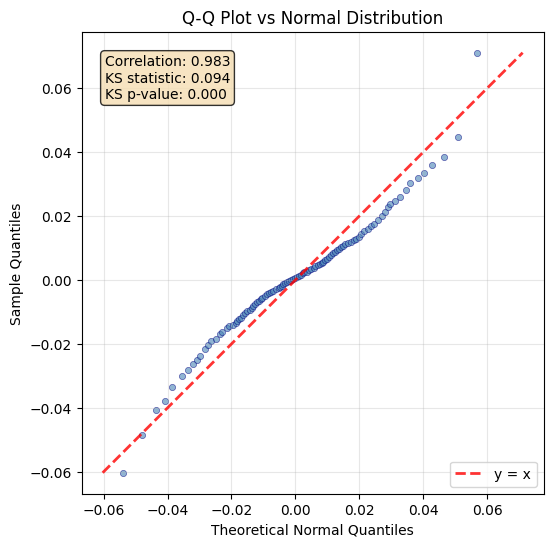

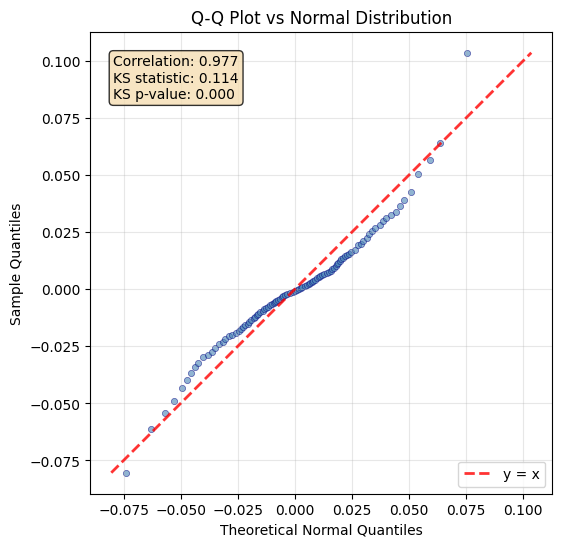

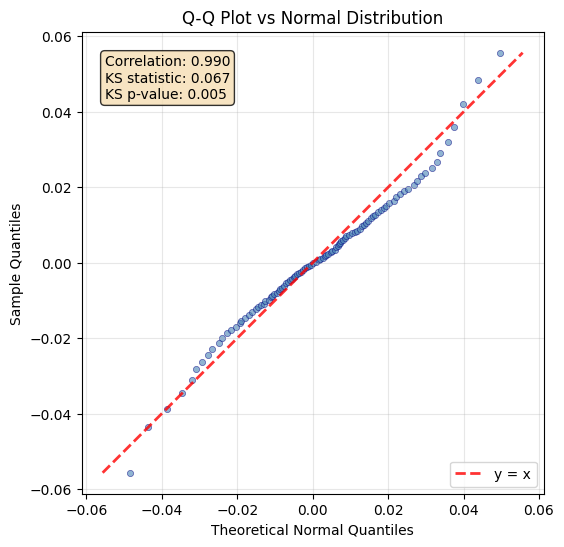

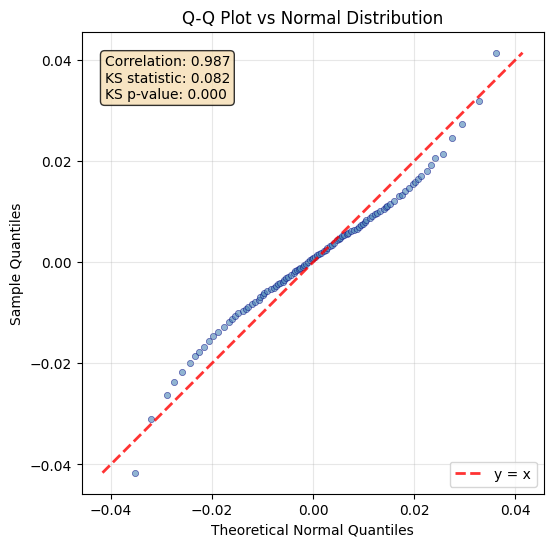

In [60]:
for i in range(0,5):
    _=qqplot_against_normal(data=data_np[:,i] )
    plt.show()
    plt.close()

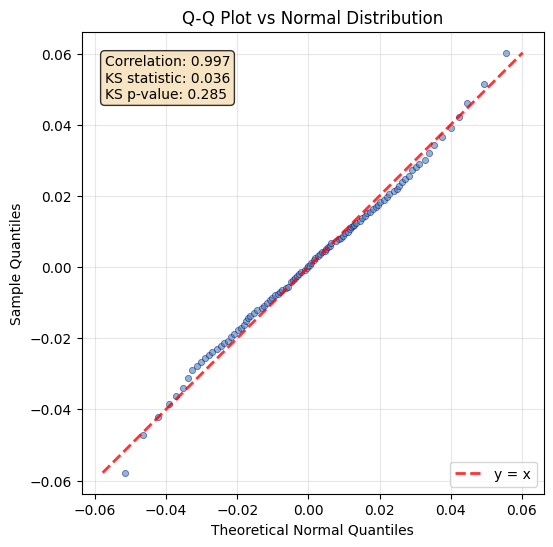

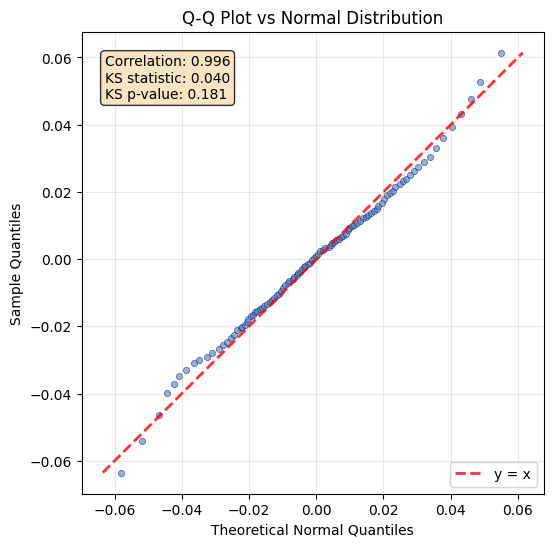

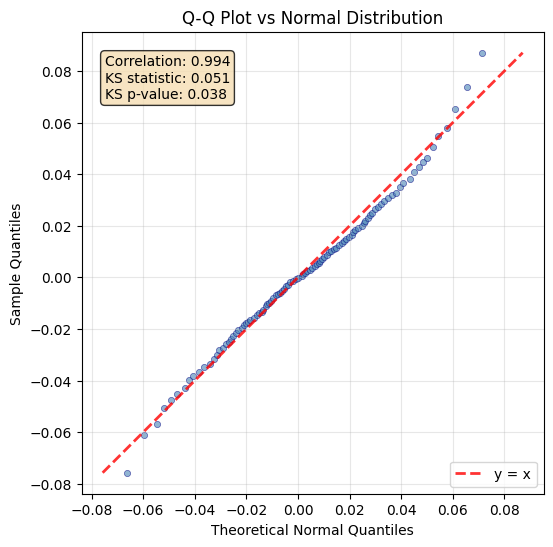

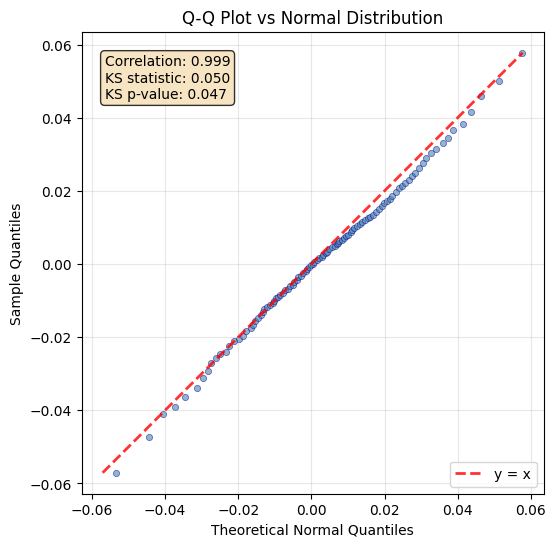

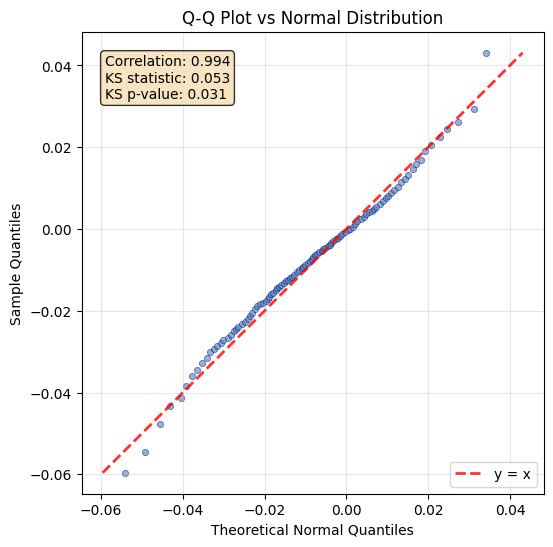

In [61]:
for i in range(0,5):
    _=qqplot_against_normal(data=synthetic_data_np[:,i] )
    plt.show()
    plt.close()

In [62]:
?qqplot

Signature:
qqplot(
    x: Union[numpy.ndarray, list],
    y: Union[numpy.ndarray, list],
    quantiles: Optional[numpy.ndarray] = None,
    interpolation: str = 'linear',
    ax: Optional[matplotlib.axes._axes.Axes] = None,
    figsize: Tuple[int, int] = (8, 6),
    title: str = 'Q-Q Plot',
    xlabel: str = 'X Quantiles',
    ylabel: str = 'Y Quantiles',
    show_stats: bool = True,
    reference_line: bool = True,
    alpha: float = 0.6,
    s: float = 20,
) -> matplotlib.axes._axes.Axes
Docstring:
Create a quantile-quantile (Q-Q) plot comparing two distributions.

Parameters:
-----------
x : array-like
    First dataset
y : array-like
    Second dataset
quantiles : array-like, optional
    Quantiles to compute. If None, uses evenly spaced quantiles from 0.01 to 0.99
interpolation : str, default 'linear'
    Interpolation method for quantile calculation
ax : matplotlib.axes.Axes, optional
    Existing axes to plot on. If None, creates new figure
figsize : tuple, default (8, 6)
    Fi

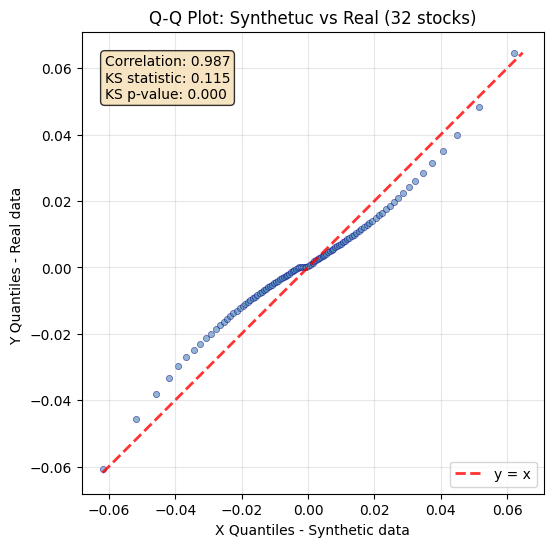

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Flatten the arrays (concatenate all columns)
synthetic_flat = synthetic_data_np.flatten()
real_flat = data_np.flatten()

_=qqplot(x=synthetic_flat , 
         y=real_flat,
        title  = 'Q-Q Plot: Synthetuc vs Real (32 stocks)',
    xlabel  = 'X Quantiles - Synthetic data',
    ylabel  = 'Y Quantiles - Real data ',)
plt.show()
plt.close()

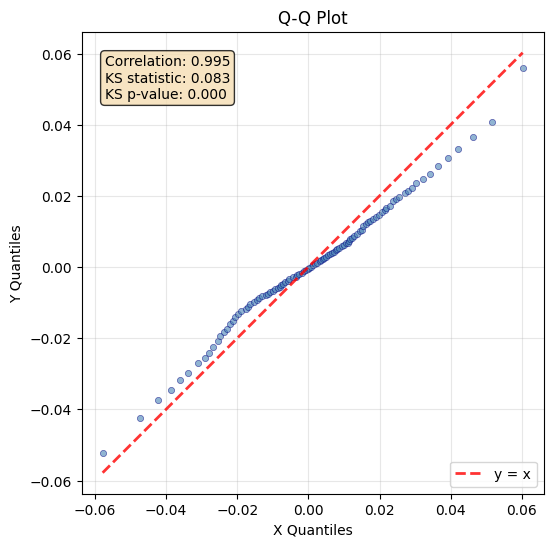

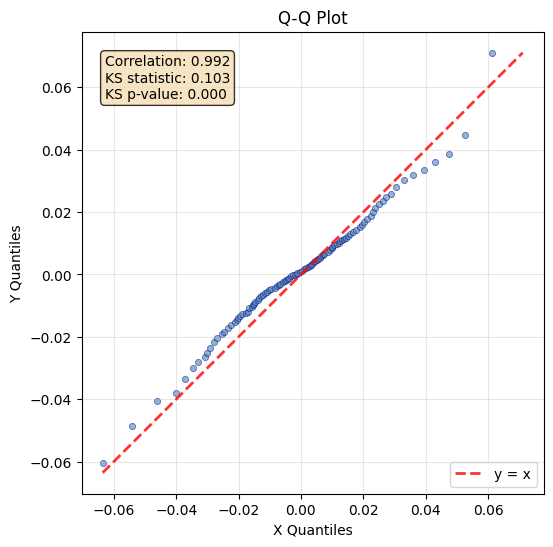

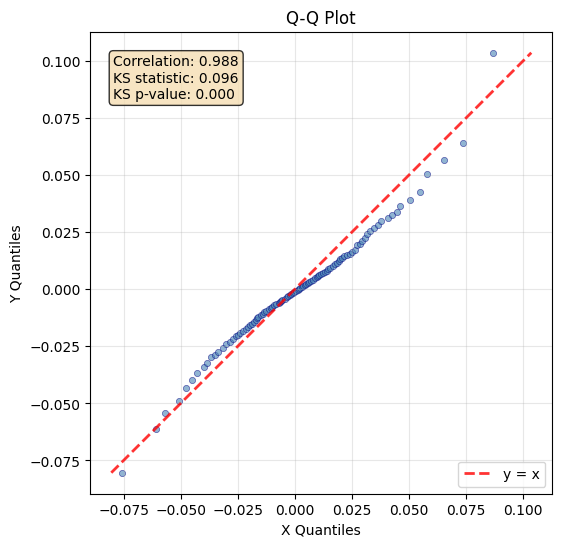

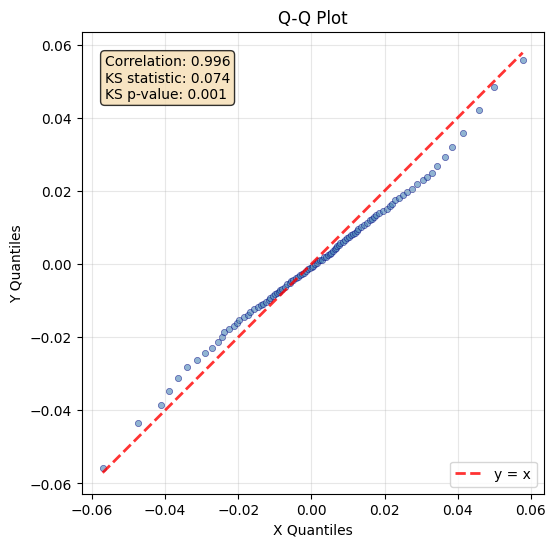

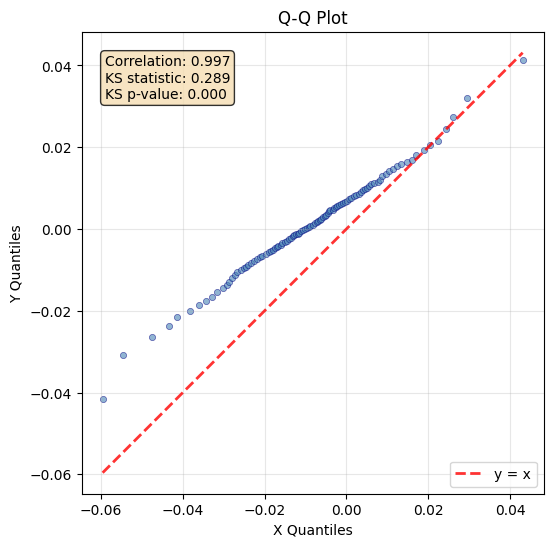

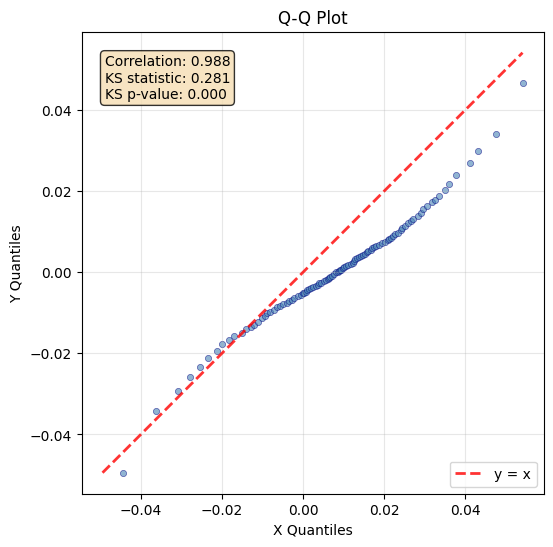

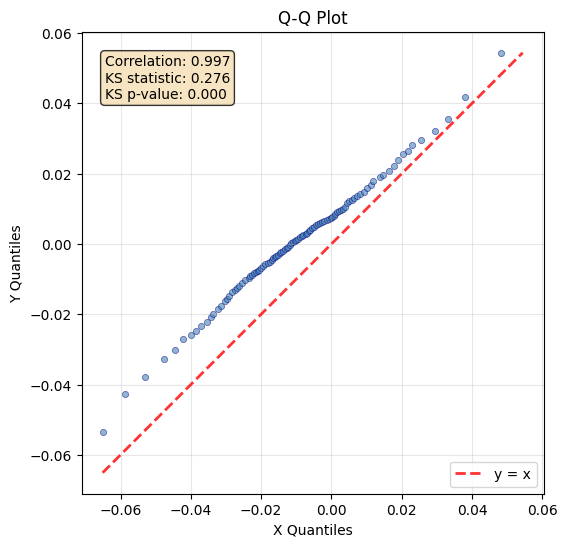

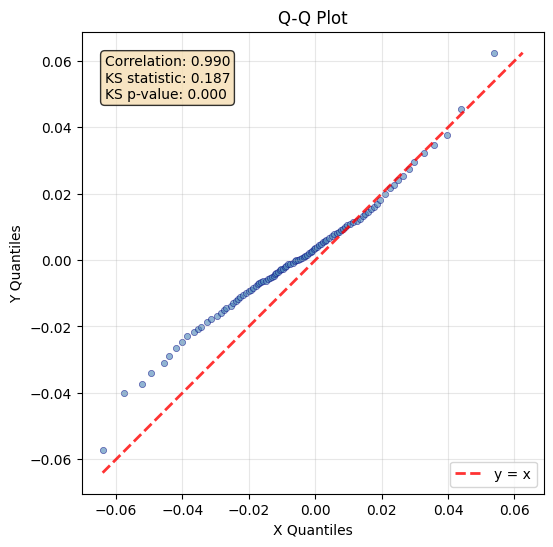

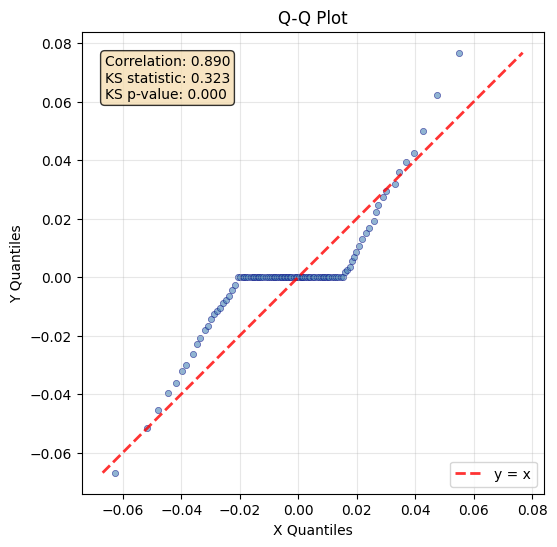

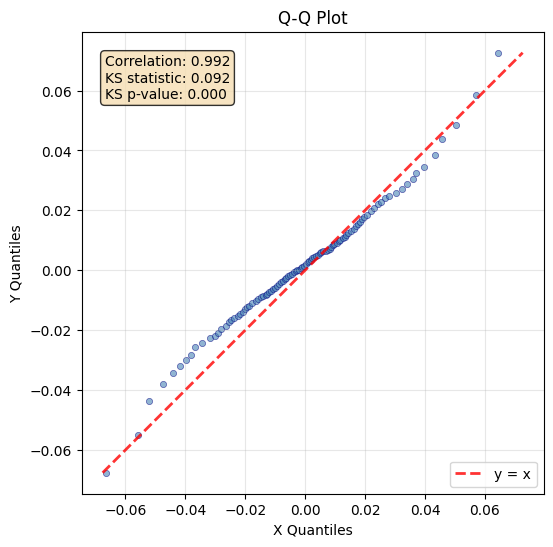

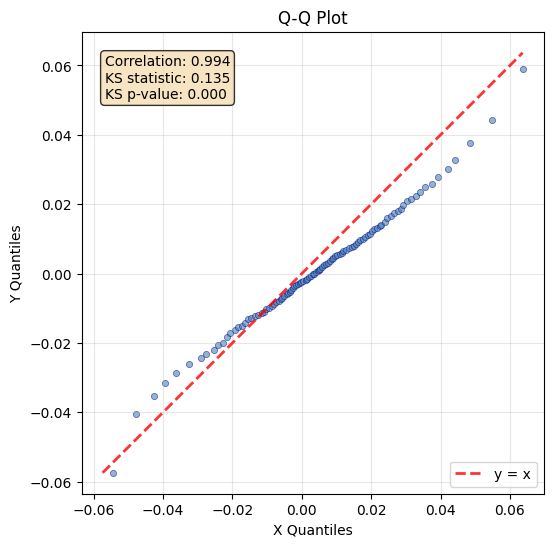

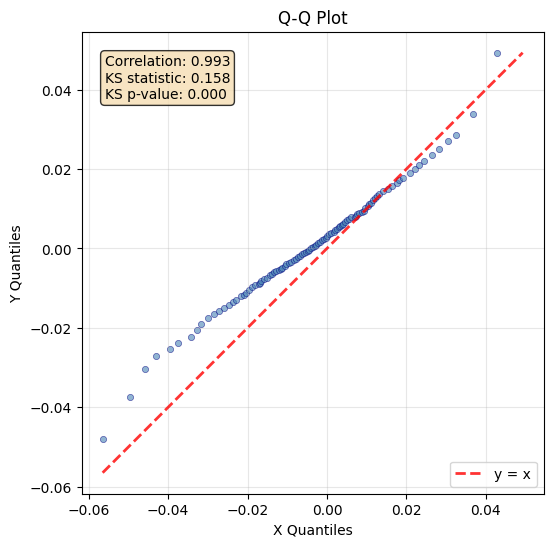

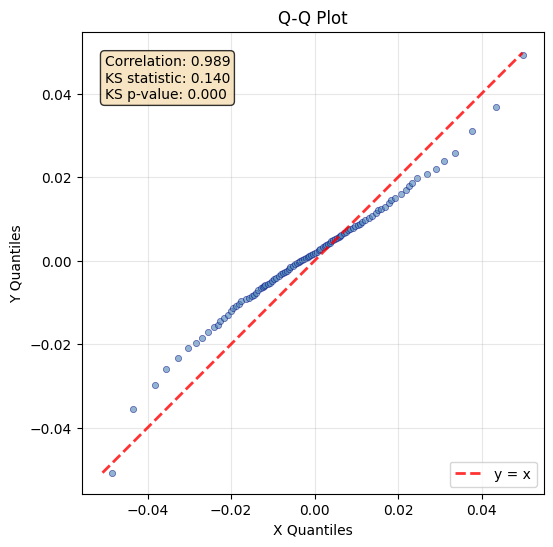

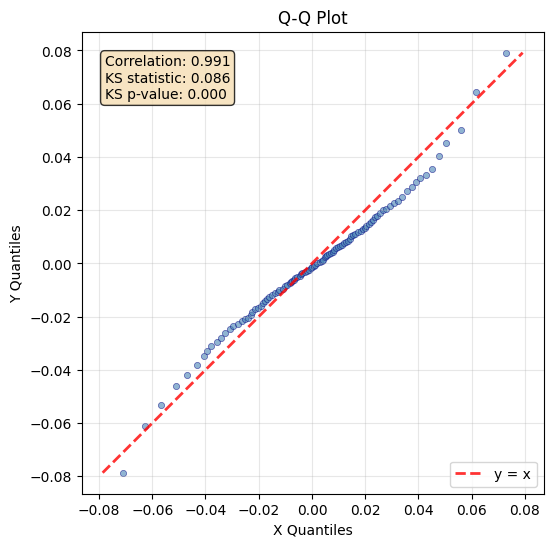

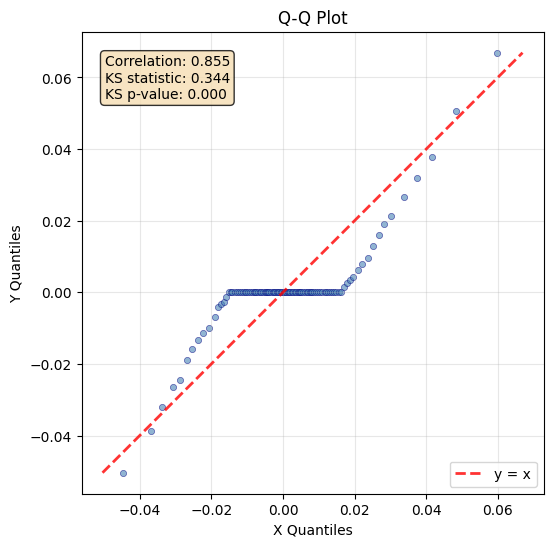

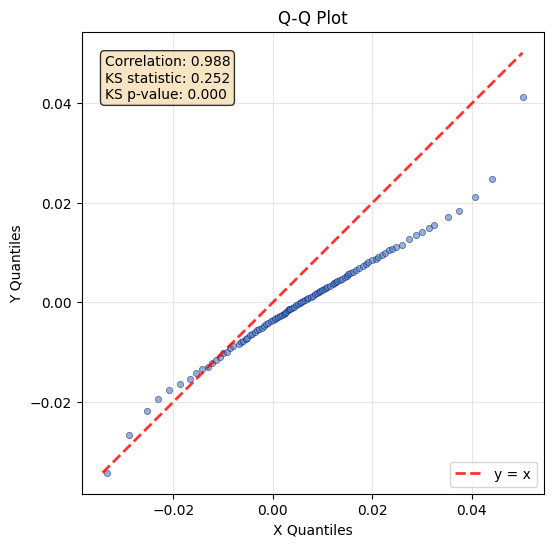

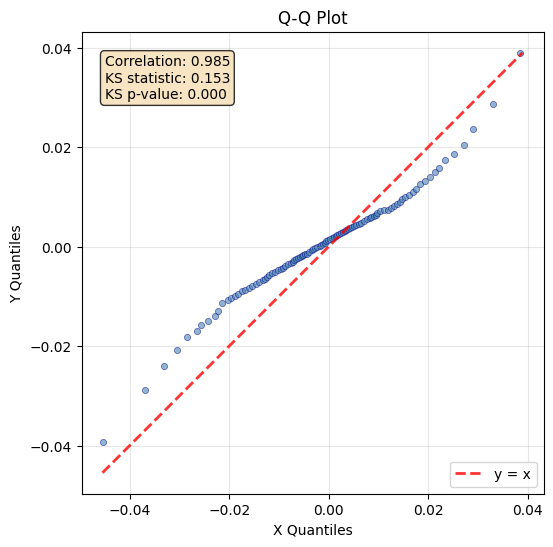

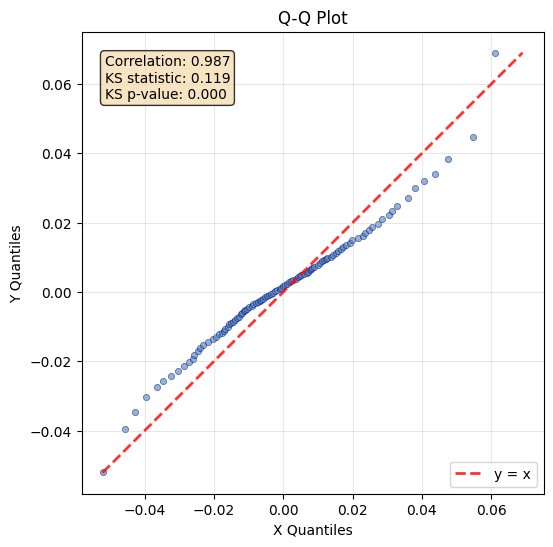

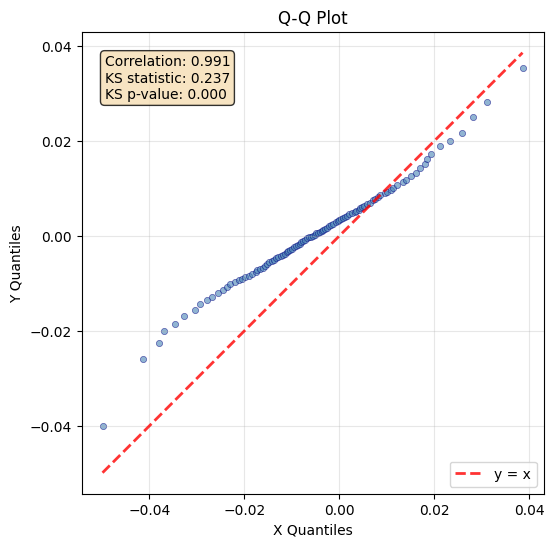

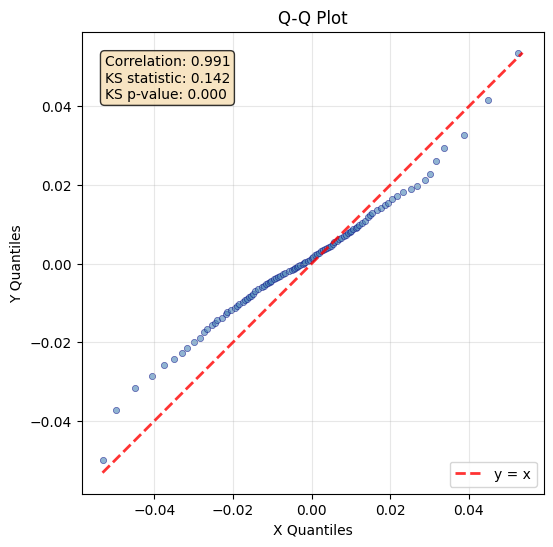

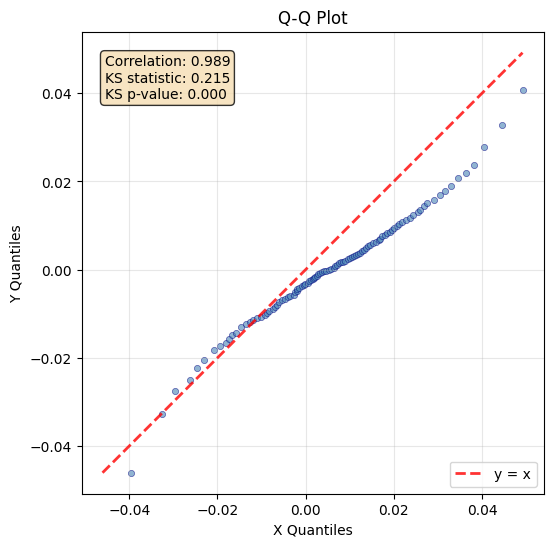

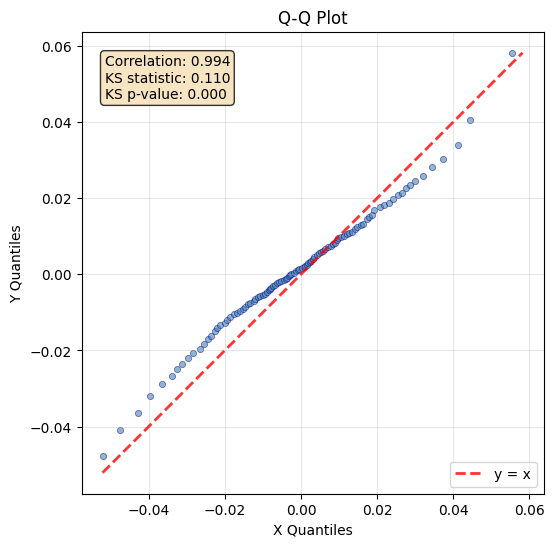

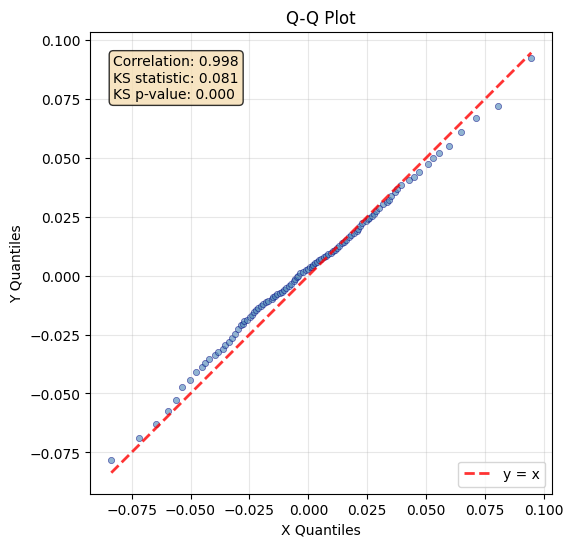

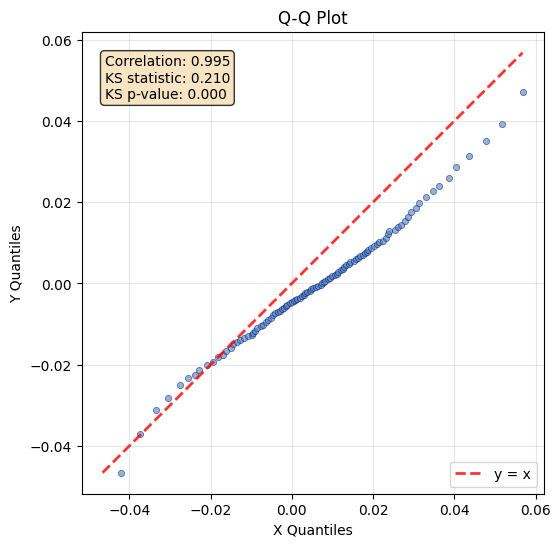

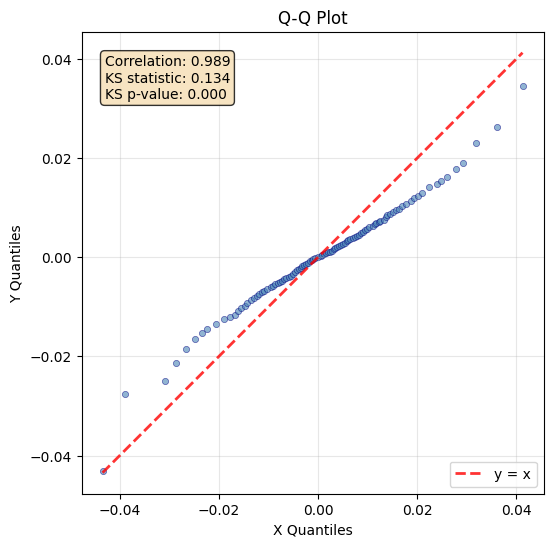

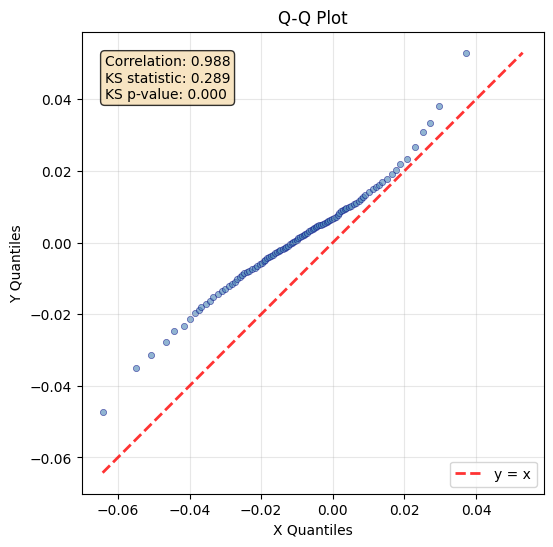

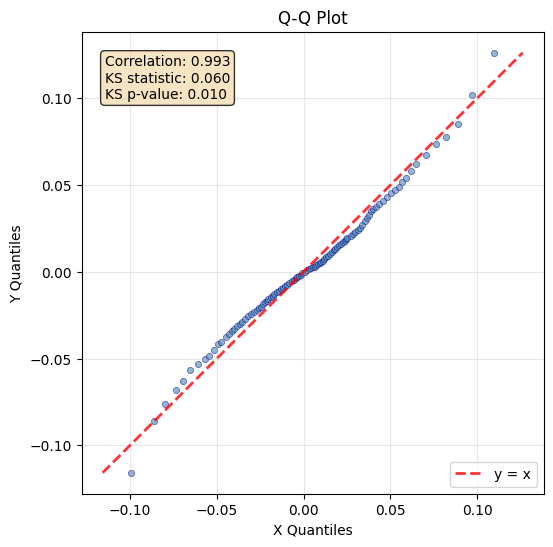

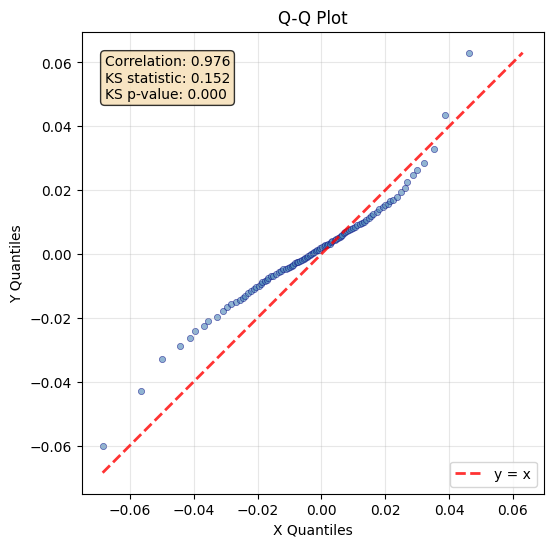

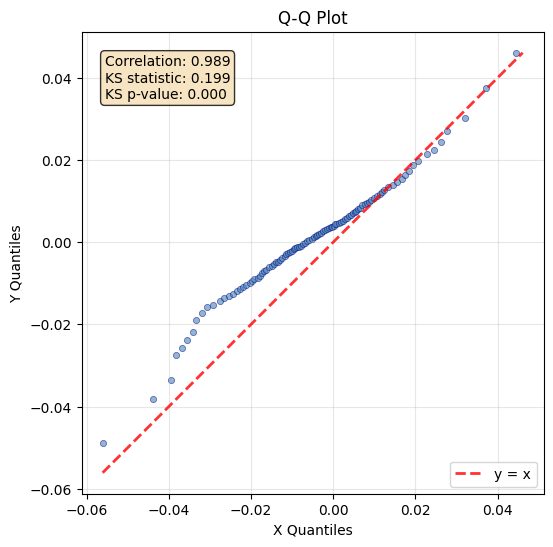

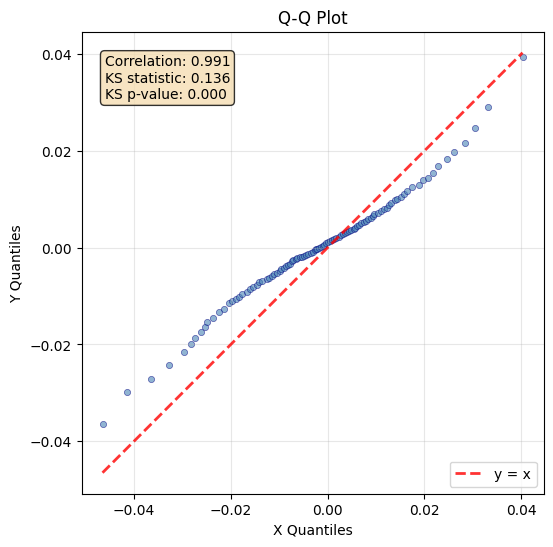

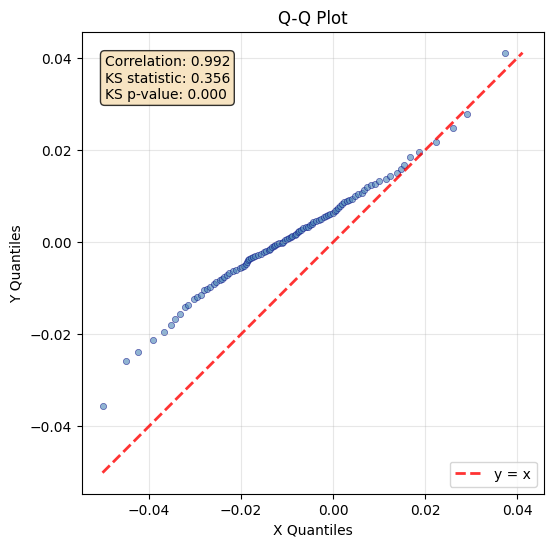

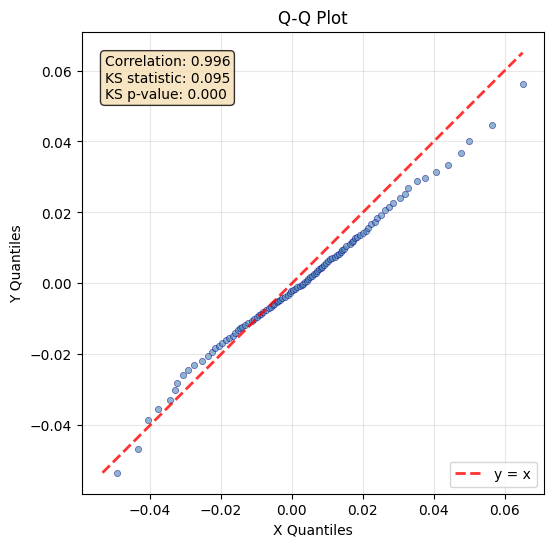

In [64]:
for i in range(0,32):
    _=qqplot(x=synthetic_data_np[:,i] , y=data_np[:,i] )
    plt.show()
    plt.close()

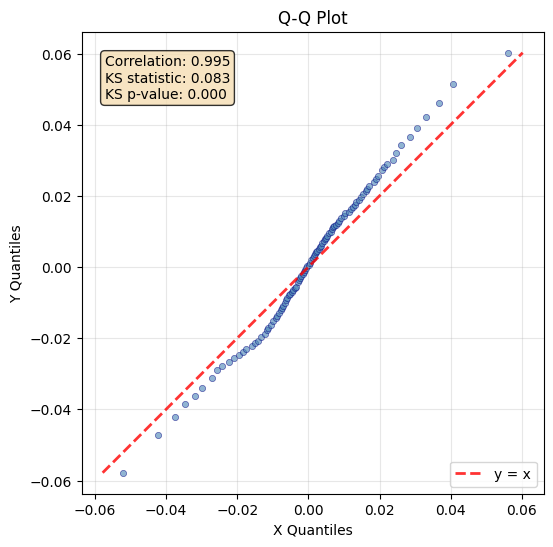

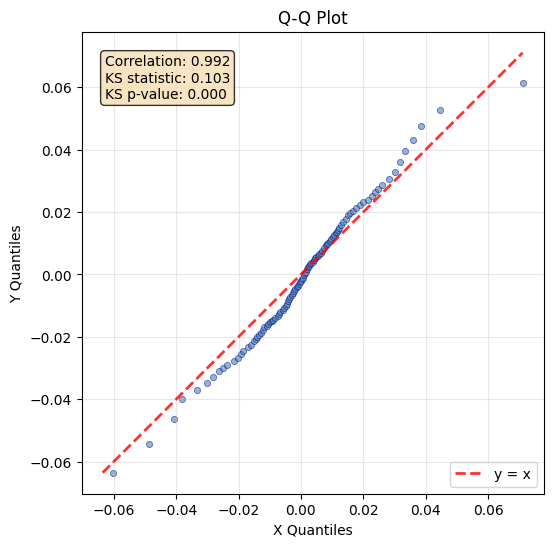

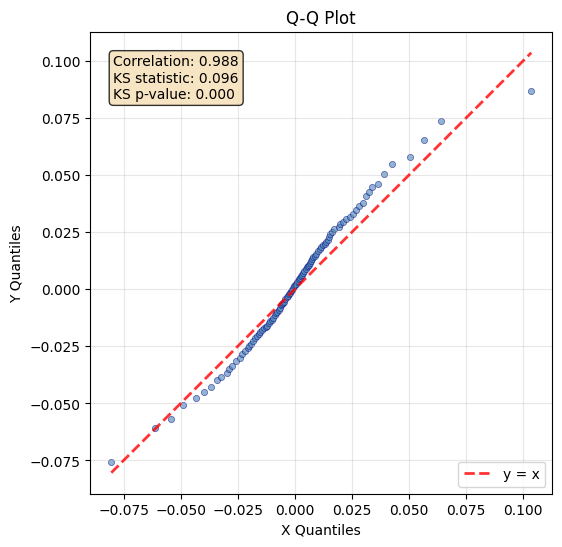

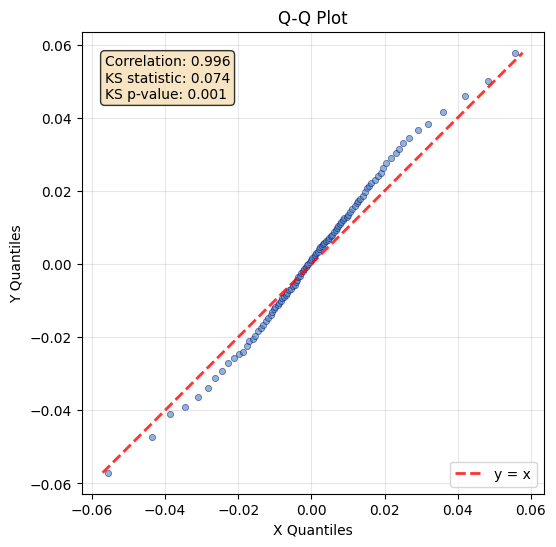

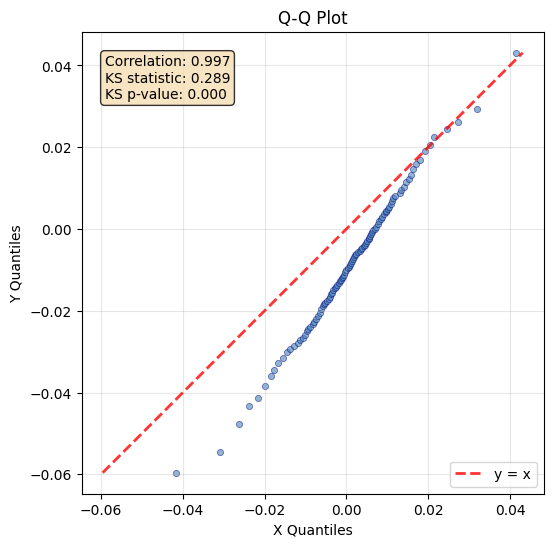

In [65]:
for i in range(0,5):
    _=qqplot(x=data_np[:,i], y= synthetic_data_np[:,i])
    plt.show()
    plt.close()